In [1]:
import os, sys
sys.path.append('/global/home/users/alexandregeorges/Chapter1/')

import dask.dataframe as dd
from codebase.utils import *
from codebase.metrics import *
from codebase.params import *

import pandas as pd
import xarray as xr

In [4]:
site_code = 'GPHT'

In [5]:
ndvi = pd.read_csv(CLASSIFIED_PREFIX+site_code+'_NDVI.csv')
uvvr = pd.read_csv(CLASSIFIED_PREFIX+site_code+'_UVVR.csv')
ndvi

,dates,GPHT,days_from_start,linfit,ndates
0,2010-01-15,0.598161,0,0.506580,2010-01-15
1,2010-01-23,0.556884,8,0.506712,2010-01-23
2,2010-01-28,0.594916,13,0.506795,2010-01-28
3,2010-02-02,0.566488,18,0.506878,2010-02-02
4,2010-04-05,0.488517,80,0.507904,2010-04-05
...,...,...,...,...,...
68,2018-12-30,0.611684,3271,0.560724,2018-12-30
69,2019-12-27,0.650902,3633,0.566716,2019-12-27
70,2020-01-11,0.597718,3648,0.566964,2020-01-11
71,2020-01-20,0.612044,3657,0.567113,2020-01-20


<Axes: xlabel='ndates'>

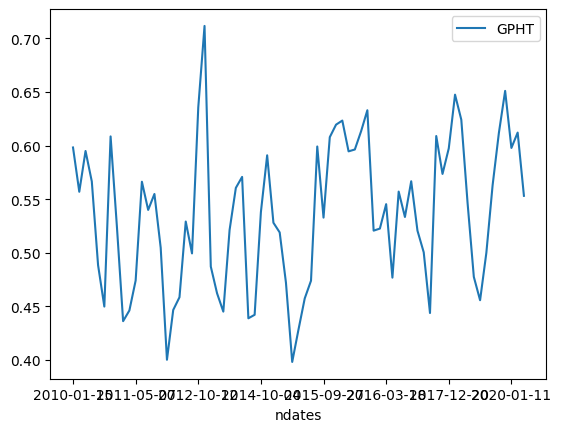

In [9]:
ndvi.plot(x='ndates', y='GPHT')